<a href="https://colab.research.google.com/github/dadecampo/CVDeepLearning/blob/main/wGrapesFasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from albumentations.core.composition import Compose
from albumentations.pytorch.transforms import ToTensorV2

from albumentations.augmentations.geometric.transforms import HorizontalFlip
from albumentations.augmentations.geometric.rotate import Rotate
from albumentations.augmentations.crops.transforms import BBoxSafeRandomCrop
from albumentations.augmentations.transforms import ColorJitter
from albumentations.augmentations.geometric.resize import Resize
from albumentations.augmentations.geometric.resize import RandomScale
import random

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 1
EPOCHS = 5
IMAGE_WIDTH = 1200
IMAGE_HEIGHT = 700
FILES_DIR = "dataset/Calibrated_Images"

def get_transform(train):
  if train:
    return Compose(
      [
        HorizontalFlip(p=0.5),
        Rotate(limit=20, p=0.5),
        RandomScale(scale_limit=0.4, interpolation = cv2.INTER_LINEAR, p=0.5),
        BBoxSafeRandomCrop(p=0.5),
        ColorJitter(random.uniform(0,0.2), random.uniform(0,0.2), random.uniform(0,0.2), random.uniform(0,0.2), p=0.5),
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return Compose(
      [
      ToTensorV2(p=1.0)
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )


In [139]:

class GrapeDataset(torch.utils.data.Dataset):
    def __init__(self, root, width, height, transforms = None):
        self.transforms = transforms
        self.root = root

        self.width = width
        self.height = height

        self.imgs=[]
        boxes_files=[]
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if file.endswith(".txt") and not file.startswith("_counting"):
                    boxes_files.append(os.path.join(root, file))
                if file.endswith(".jpg") or file.endswith(".JPG")  :
                    self.imgs.append(os.path.join(root, file))
                if file.startswith("_counting"):
                   self.conting_file = os.path.join(root, "_counting.txt")
        self.imgs = sorted(self.imgs)
        boxes_files = sorted(boxes_files)
        self.boxes = boxes_files

    def __getitem__(self, idx):
        # get image and boxes
        img_path = self.imgs[idx]
        box_path = self.boxes[idx]
        # image elaboration
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0

        height, width, _ = img.shape
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        labels=[]
        boxes=[]
        with open(box_path) as f:
            for line in f:
                labels.append(1)

                elems=[float(x) for x in line.split(' ')]

                x_center = int(elems[1] * width)
                y_center = int(elems[2] * height)
                box_wt = int(elems[3] * width)
                box_ht = int(elems[4] * height)

                x_min = max(0.0, x_center - box_wt/2)
                x_max  = min(width, x_center + box_wt/2)
                y_min = max(0.0, y_center - box_ht/2)
                y_max  = min(height, y_center + box_ht/2)

                boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels= torch.as_tensor(labels, dtype=torch.int64)
        iscrowd= torch.zeros((boxes.shape[0],),dtype=torch.int64)
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        target={}
        target["boxes"] = boxes
        target["area"] = area
        target["labels"]= labels
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img,
                                bboxes = target['boxes'],
                                labels = labels)
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img, target

    def __len__(self):
        return len(self.imgs)



In [140]:
    
def plot_img_bbox(img, target, prediction):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, ax = plt.subplots(2,1)
  fig.set_size_inches(5,5)
  img=img.permute(1,2,0)
  ax[0].imshow(img)
  ax[1].imshow(img)

  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax[0].add_patch(rect)

  for box in (prediction['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax[1].add_patch(rect)
  plt.show()
    

In [141]:
from tqdm.notebook import tqdm 
import time
import torch
import numpy

loss_objectness = []
loss_box_reg = []
loss_classifier= []

def train_epoch(model, optimizer, data_loader, device, epoch):
        model.train()

        for i, (images, targets) in (tepoch := tqdm(enumerate(data_loader), unit="batch", total=len(data_loader))):
            tepoch.set_description(f"Epoch {epoch}")
            # Step 1: send the image to the required device.
            # Images is a list of B images (where B = batch_size of the DataLoader).
            images = list(img.to(device) for img in images)
            # Step 2: send each target to the required device
            # Targets is a dictionary of metadata. each (k,v) pair is a metadata
            # required for training.
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model_time = time.time()
            loss_dict=model(images, targets)
            
            loss_objectness.append(loss_dict["loss_objectness"].cpu().detach().numpy())
            loss_box_reg.append(loss_dict["loss_box_reg"].cpu().detach().numpy())
            loss_classifier.append(loss_dict["loss_classifier"].cpu().detach().numpy())

            model_time = time.time() - model_time
            # Step 3. backward on loss.
            # Normally, you would obtain the loss from the model.forward()
            # and then just call .bacward() on it.
            # In this case, for each task, you have a different loss, due to
            # different error metrics adopted by the tasks.
            # One typical approach is to combine all the losses to one single loss,
            # and then then backward that single loss.
            # In this way you can adjust the weight of the different tasks,
            # multiplying each loss for a hyperparemeter.
            # E.G.:
            #       final_loss = loss_1 + gamma*(alpha*loss_2 + beta*loss_3)
            # In this case, we want to sum up all the losses.
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            tepoch.set_postfix(loss=losses.item())

In [142]:
import random
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torchvision import transforms as torchtrans
from detection.engine import train_one_epoch, evaluate
import detection.utils
import detection.transforms as T
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet, RetinaNet_ResNet50_FPN_V2_Weights, FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models import ResNet50_Weights, resnet101
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, RetinaNetRegressionHead
from functools import partial
from tqdm.notebook import tqdm 
import gc


# use our dataset and defined transformations
dataset = GrapeDataset(FILES_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, transforms=get_transform(train=True))
dataset_test = GrapeDataset(FILES_DIR, IMAGE_WIDTH, IMAGE_HEIGHT,  transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(random.randint(0,100))
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])
print(len(dataset))
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=detection.utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=detection.utils.collate_fn,
)

def get_object_detection_model(num_classes):

    #weights = RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1
    #model = torchvision.models.detection.retinanet_resnet50_fpn_v2(
    #    weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1
    #)
    torch.cuda.empty_cache()
    gc.collect()
    model = torchvision.models.detection.faster_rcnn.fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    model.roi_heads.box_predictor.cls_score = torch.nn.Linear(
        in_features=in_features, out_features=num_classes, bias=True
    )
    model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(
        in_features=in_features, out_features=num_classes*4, bias=True
    )
    return model

# train on gpu if available

num_classes = 2 # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(DEVICE)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

for epoch in range(EPOCHS):
    # training for one epoch
    train_epoch(model, optimizer, data_loader, DEVICE, epoch)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset



216


d:\Anaconda\envs\cvDeepLearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/216 [00:00<?, ?batch/s]

  0%|          | 0/216 [00:00<?, ?batch/s]

  0%|          | 0/216 [00:00<?, ?batch/s]

  0%|          | 0/216 [00:00<?, ?batch/s]

  0%|          | 0/216 [00:00<?, ?batch/s]

In [143]:
coco = evaluate(model, data_loader_test, device=DEVICE)

creating index...
index created!
Test:  [ 0/54]  eta: 0:00:18  model_time: 0.2143 (0.2143)  evaluator_time: 0.0020 (0.0020)  time: 0.3515  data: 0.1321  max mem: 9065
Test:  [53/54]  eta: 0:00:00  model_time: 0.0639 (0.0717)  evaluator_time: 0.0011 (0.0033)  time: 0.2355  data: 0.1629  max mem: 9065
Test: Total time: 0:00:14 (0.2768 s / it)
Averaged stats: model_time: 0.0639 (0.0717)  evaluator_time: 0.0011 (0.0033)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.435
 Average Recall     (AR) @[ IoU=

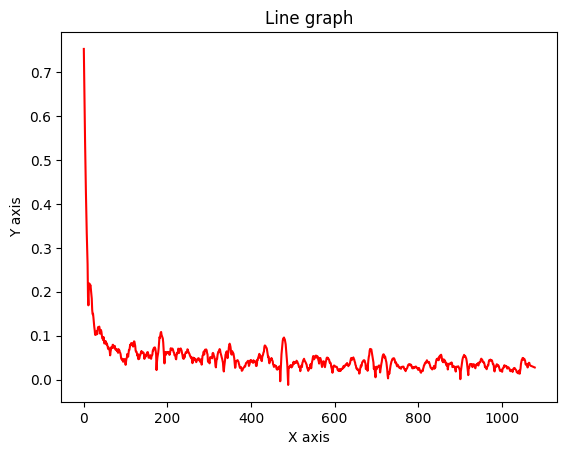

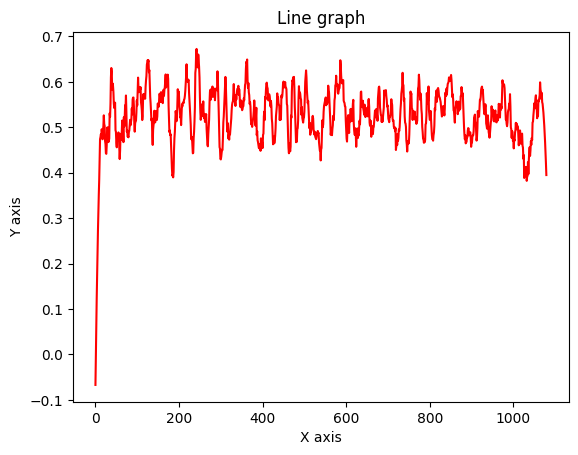

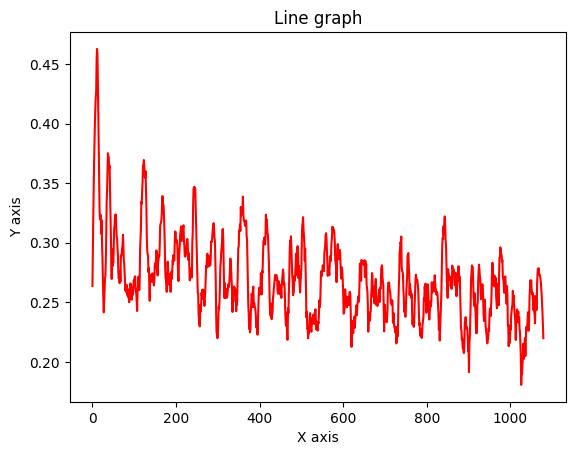

In [146]:
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter
window = 20
order = 2

x=np.array([i for i in range(len(loss_objectness)) ])
poly_y = savgol_filter(np.array(loss_objectness), window, order)

plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(x, poly_y, color = "red")
plt.show()

x=np.array([i for i in range(len(loss_box_reg)) ])
poly_y = savgol_filter(np.array(loss_box_reg), window, order)

plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(x, poly_y, color = "red")
plt.show()


x=np.array([i for i in range(len(loss_classifier)) ])
poly_y = savgol_filter(np.array(loss_classifier), window, order)

plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(x, poly_y, color = "red")
plt.show()


# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'].cpu(), orig_prediction['scores'].cpu(), iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'].cpu()[keep]
    final_prediction['scores'] = final_prediction['scores'].cpu()[keep]
    final_prediction['labels'] = final_prediction['labels'].cpu()[keep]
    
    return final_prediction

MODEL OUTPUT



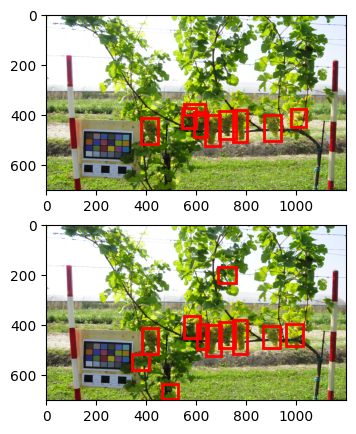

In [153]:
    
# pick one image from the test set
img, target = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(DEVICE)])[0]


print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.3)

plot_img_bbox(img, target, nms_prediction)